#**Geospatial analyses using WaPOR data**
#Topic 3 - Notebook 4: Average Seasonal Evapotranspiration for area of interest
In this notebook we will use the WaPOR AETI data downloaded through the Topic3_N01 notebook and shapefile of wheat field in Gezira irrigation scheme and calculate the seasonal AETI per plot and decadal timeseries of AETI for each plot.   
The steps are:
1. Install and load necessary packages to manage raster files
2. Load the .zip file from Topc3_N01 to this session (or create a new .zip)
3. Unzip files
4. Get the list of files from uploaded zipped file
5. Perform the temporal aggregation (sum) of the decadal AETI
6. Zonal statistics (compute average AETI per plot for one filed)
7. Saving the dataframes computed above to csv files and downlaod them to local folder
8. Exercises
9. Bonus - Compute time series of decadal AETI per plot.





---



### **Step 1**

In [1]:
# Install required packages
%%capture
!pip install --upgrade xarray  --quiet
!pip install --upgrade geopandas --quiet
!pip install --upgrade rioxarray --quiet

In [2]:
# Import the required packages
from osgeo import gdal
import xarray as xr
import rioxarray as rio
import numpy as np
import pandas as pd
import geopandas as gpd
import glob
import os

### **N.B.**
>In this notebook we used additional python packages called <font color='steelblue'>**`Xarray`**</font> and <font color='steelblue'>**`rioxarray`**</font>. <font color='steelblue'>**`Xarray`**</font> is a python library which simplifies working with labelled multi-dimension arrays such as stack of rasters and<font color='steelblue'>**`rioxarray`**</font> is an Xarray extension that allows reading and writing a wide variety of geospatial image formats compatible with Geographic Information Systems (GIS). Introducing these packages is out of the scope of this notebook, but **[here](https://tutorial.xarray.dev/overview/xarray-in-45-min.html)** and **[here](https://corteva.github.io/rioxarray/html/getting_started/getting_started.html)** you can find good introductions about the packages which provid you the basic understanding.



---





---



### **Step 2 - Upload .zip to your colab files**
We will now upload the .zip file.
Execute the command below, click the `Choose Files` button, navigate to where you have saved the .zip file in your local drive and select the zipped file.

In [3]:
#To upload file.
from google.colab import files
uploaded = files.upload()

Saving WaPOR_data.zip to WaPOR_data.zip




---



### **Step 3 - Unzip files**
Unzip the file you have uploaded.
The command is:
 !unzip 'file_path.zip' -d 'folder_to_unzip_path'
Replace the file name in the cell below with the name of your own file. You can find the path to your file by clicking on the 3 dots next to the file name in your file explorer to the left and selecting *Copy path*. (If you do not see your files to the left, click on the folder icon to expand the Files panel)

In [4]:
# unzip the uploaded zipfile
!unzip '/content/WaPOR_data.zip' -d '/content/'

Archive:  /content/WaPOR_data.zip
   creating: /content/WaPOR_data/L3-AETI-D/
  inflating: /content/WaPOR_data/L3-AETI-D/Wad_Helal_projected.GEZ_L3-AETI-D_NONE_dekad_converted_2022-10-01.tif  
  inflating: /content/WaPOR_data/L3-AETI-D/Wad_Helal_projected.GEZ_L3-AETI-D_NONE_dekad_converted_2022-10-11.tif  
  inflating: /content/WaPOR_data/L3-AETI-D/Wad_Helal_projected.GEZ_L3-AETI-D_NONE_dekad_converted_2022-10-21.tif  
  inflating: /content/WaPOR_data/L3-AETI-D/Wad_Helal_projected.GEZ_L3-AETI-D_NONE_dekad_converted_2022-11-01.tif  
  inflating: /content/WaPOR_data/L3-AETI-D/Wad_Helal_projected.GEZ_L3-AETI-D_NONE_dekad_converted_2022-11-11.tif  
  inflating: /content/WaPOR_data/L3-AETI-D/Wad_Helal_projected.GEZ_L3-AETI-D_NONE_dekad_converted_2022-11-21.tif  
  inflating: /content/WaPOR_data/L3-AETI-D/Wad_Helal_projected.GEZ_L3-AETI-D_NONE_dekad_converted_2022-12-01.tif  
  inflating: /content/WaPOR_data/L3-AETI-D/Wad_Helal_projected.GEZ_L3-AETI-D_NONE_dekad_converted_2022-12-11.tif  
  


### **Step 4 - Get the list of files from uploaded zipped file**
The list of files can be obtained in the following way.
```python
# Example to get all the files with '.tif' extension
glob.glob('/content/WaPOR_data/L3-AETI-D/*.tif')
```



In [5]:
rst_fh = glob.glob('/content/WaPOR_data/L3-AETI-D/*.tif')
rst_fh # this holds the list of raster files found in the 'L3-AETI-D.zip' file.

['/content/WaPOR_data/L3-AETI-D/Wad_Helal_projected.GEZ_L3-AETI-D_NONE_dekad_converted_2022-12-21.tif',
 '/content/WaPOR_data/L3-AETI-D/Wad_Helal_projected.GEZ_L3-AETI-D_NONE_dekad_converted_2022-10-21.tif',
 '/content/WaPOR_data/L3-AETI-D/Wad_Helal_projected.GEZ_L3-AETI-D_NONE_dekad_converted_2023-04-01.tif',
 '/content/WaPOR_data/L3-AETI-D/Wad_Helal_projected.GEZ_L3-AETI-D_NONE_dekad_converted_2022-10-01.tif',
 '/content/WaPOR_data/L3-AETI-D/Wad_Helal_projected.GEZ_L3-AETI-D_NONE_dekad_converted_2023-01-01.tif',
 '/content/WaPOR_data/L3-AETI-D/Wad_Helal_projected.GEZ_L3-AETI-D_NONE_dekad_converted_2023-03-21.tif',
 '/content/WaPOR_data/L3-AETI-D/Wad_Helal_projected.GEZ_L3-AETI-D_NONE_dekad_converted_2022-11-11.tif',
 '/content/WaPOR_data/L3-AETI-D/Wad_Helal_projected.GEZ_L3-AETI-D_NONE_dekad_converted_2023-03-11.tif',
 '/content/WaPOR_data/L3-AETI-D/Wad_Helal_projected.GEZ_L3-AETI-D_NONE_dekad_converted_2022-11-01.tif',
 '/content/WaPOR_data/L3-AETI-D/Wad_Helal_projected.GEZ_L3-AETI-



---



### **Step 5: Perform the temporal aggregation (sum) of the decadal AETI**

We create an xarray dataarray from the raster files so that any further computation is easier to do

In [6]:
# Create an xarray dataarray from the raster files so that any further computation is easier to do

# get the time of the rasters from filenames
time = [pd.to_datetime(i[-14:-4], format='%Y-%m-%d') for i in rst_fh]

# read the first raster to get the crs and scale_factor
tif_0 = rio.open_rasterio(rst_fh[0])
crs = tif_0.rio.crs
scale_factor = tif_0.attrs['scale_factor']

# read each raster and concatenate them to create an xarray dataarray
ds = xr.concat([rio.open_rasterio(f) for f in rst_fh], dim=time)
ds = ds.squeeze(dim = 'band', drop = True)
ds = ds.drop_vars(['spatial_ref'])

# rename the dimnesions of the dataarray
ds = ds.rename({'concat_dim':'time','x': 'longitude','y': 'latitude'})

# multiply the data by the scale factor
ds = ds.where(ds !=ds.attrs['_FillValue'])*scale_factor

# write CRS information to the dataarray
ds = ds.rio.write_crs(crs, inplace=True)

# update the attributes of the dataarray
attrs = ds.attrs
attrs.update({'start_date': '2022-10-01',
              'end_date': '2023-04-30',
              '_FillValue': np.nan})
attrs_to_delet = [i for i in attrs if 'STATISTICS_' in i]
attrs_to_delet.append('number_of_days')
attrs_new = {key: attrs[key] for key in attrs if key not in attrs_to_delet}

ds.attrs  = attrs_new

### Compute the seasonal sum of AETI

In [7]:
# We can sum up all the decadal taster to seasonal raster.
seasonal_year='YE-{0}'.format('Nov')  # the season we use is from November 2022 to April 2023
# sum the decadal AETI to seasonal AETI
ds_season = ds.sum(dim='time',skipna=False)
ds_season = ds_season.drop_vars(['spatial_ref'])
ds_season = ds_season.rename('Seasonal AETI')
ds_season = ds_season.rio.write_crs(crs)
ds_season

<xarray.DataArray 'Seasonal AETI' (latitude: 460, longitude: 754)> Size: 3MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * longitude    (longitude) float64 6kB 5.16e+05 5.16e+05 ... 5.31e+05 5.31e+05
  * latitude     (latitude) float64 4kB 1.586e+06 1.586e+06 ... 1.577e+06
    spatial_ref  int64 8B 0

### Update attributes of the seasonal dataarray



In [8]:
attrs = ds_season.attrs
attrs.update({'start_date': '2022-10-01',
              'end_date': '2023-04-30',
              'units' : 'mm/sdeceason',
              'temporal_resolution' : 'Seasonal'})
attrs_to_delet = [i for i in attrs if 'STATISTICS_' in i]
attrs_to_delet.append('number_of_days')
attrs_new = {key: attrs[key] for key in attrs if key not in attrs_to_delet}

ds_season.attrs  = attrs_new

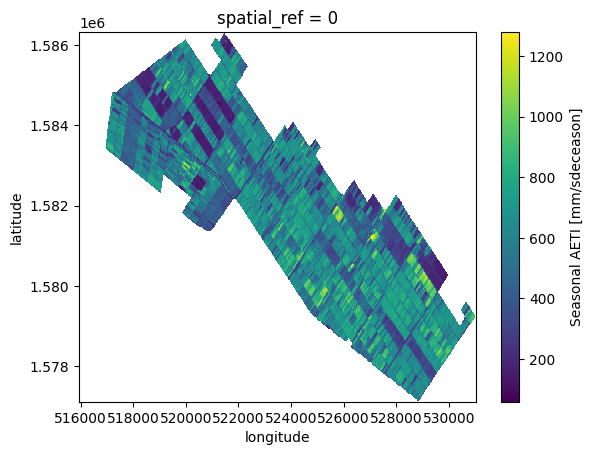

In [9]:
# plot the season sum AETI
ds_season.plot()



---



## **Step 6 - Zonal statistics (compute average AETI per plot for one field)**

Upload and read area of interest defined by geojson file using geopandas

In [10]:
#To upload file.
from google.colab import files
uploaded = files.upload()

Saving Fields.geojson to Fields.geojson


In [11]:
## Read polygons of fields in the are of interest for wheat fields
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)

aoi = r"/content/Fields.geojson" ## give the correct path of the geojson file here
gdf = gpd.read_file(aoi)
gdf

,id,yield,layer,path,geometry
0,3201,3.31,BahiEddin11,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"MULTIPOLYGON (((518802.239 1582439.322, 518814..."
1,3202,3.10,BahiEddin11,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"MULTIPOLYGON (((518813.176 1582497.245, 518826..."
2,3203,2.32,BahiEddin11,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"MULTIPOLYGON (((518827.493 1582553.491, 518840..."
3,3204,3.30,BahiEddin11,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"MULTIPOLYGON (((518838.855 1582607.637, 518846..."
4,3205,3.32,BahiEddin11,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"MULTIPOLYGON (((518847.277 1582639.538, 518853..."
...,...,...,...,...,...
209,1220,3.17,Hegeiliga_Median,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"MULTIPOLYGON (((528152.674 1580025.052, 528174..."
210,1221,3.17,Hegeiliga_Median,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"MULTIPOLYGON (((528174.503 1580003.671, 528195..."
211,1222,1.98,Hegeiliga_Median,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"MULTIPOLYGON (((528069.161 1580109.373, 528153..."
212,1223,2.64,Hegeiliga_Median,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"MULTIPOLYGON (((528028.463 1580149.305, 528048..."


<Axes: >

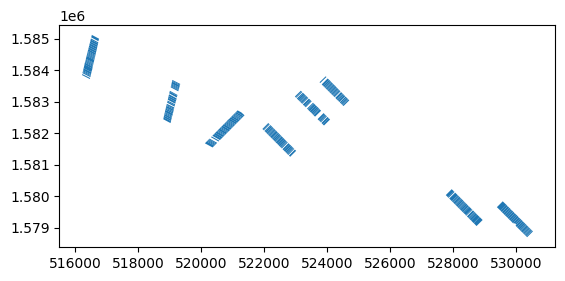

In [12]:
# Plotting the plots
gdf.plot()

As you can see from the above geopandas dataframe, there are 8 fields with several plot per filed.

You can get the name of the fields using the following code.

In [13]:
# get the name of the fields
np.unique(gdf['layer'])

array(['BahiEddin11', 'BahiEddin21', 'BahiEddin3', 'Eltukl10',
       'FakiMusa1', 'FakiMusa6', 'FakiMusa9', 'Hegeiliga_Median'],
      dtype=object)

We will use the field **`'FakiMusa6'`** as an example.we can select the rows beloging to this field.

In [14]:
## Select one of the fields (FakiMusa6)
farm_field = gdf[gdf['layer']=='FakiMusa6']
farm_field


,id,yield,layer,path,geometry
136,2201,2.25,FakiMusa6,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"MULTIPOLYGON (((524055.126 1582470.685, 524096..."
137,2202,2.60,FakiMusa6,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"MULTIPOLYGON (((523821.720 1582321.897, 524014..."
138,2203,1.98,FakiMusa6,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"MULTIPOLYGON (((523974.387 1582548.666, 523996..."
139,2204,1.81,FakiMusa6,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"MULTIPOLYGON (((523952.826 1582571.308, 523975..."
140,2205,2.38,FakiMusa6,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"MULTIPOLYGON (((523932.536 1582591.013, 523952..."
141,2206,2.25,FakiMusa6,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"MULTIPOLYGON (((523890.261 1582634.618, 523933..."
142,2207,1.69,FakiMusa6,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"MULTIPOLYGON (((523768.945 1582749.492, 523812..."
143,2208,2.38,FakiMusa6,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"MULTIPOLYGON (((523748.227 1582774.232, 523772..."
144,2209,2.64,FakiMusa6,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"MULTIPOLYGON (((523726.667 1582797.294, 523748..."
145,2210,2.18,FakiMusa6,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"MULTIPOLYGON (((523683.551 1582838.380, 523727..."


This field has several plots. you gen the number of the plots suing the code in the following cell.

In [15]:
# Number of Polygons in FakiMusa6 field
len(farm_field)

27

In [18]:
# Iterate through the plots and use the plots polygons to clip the AETI dataarray

# creat empty lists to hold the values for each plot
AETI_per_plot = [] # to hold the AETI per plot
plot_id = [] # to hold ID of the plots
plot_area = [] # to hold the area of plots

for index, row in farm_field.iterrows(): # iteration through the farm_field dataframe rows
  shdf = farm_field.loc[[index]]

  if(not shdf.geometry.item().is_empty): # check if the polygon of the plot is not empty
      da = ds_season.rio.clip(shdf.geometry, farm_field.crs,
                              all_touched=False) #same option as QGIS zonal statistics
      # compute AAETI of the polygon
      da = da.mean(dim=['latitude','longitude']).data

      AETI_per_plot.append(da) # add the AETI per polt to the AETI_per_plot list
      plot_id.append(shdf.id.values[0]) # add the ID of a plot to plot_id list
      plot_area.append(shdf.area.iloc[0]) # add area of the plot polygon to the plot_area list

# # round the numbers in AETI and area for each polygon
AETI_per_plot = [ np.around(i,2) for i in AETI_per_plot]
plot_area = [np.around(i,2) for i in plot_area]

A dataframe can be ceated using the thre lists we created in the above cell as follows:

In [19]:
# creat a Pandas dataframe from the AETI, area and ID of each polygon
data={'Plot_ID':plot_id,'Plot_mean_AETI [mm/season]':AETI_per_plot,
        'Plot_area [meter square]':plot_area}
df = pd.DataFrame(data)
df = df.sort_values('Plot_ID',ascending=True)
df

,Plot_ID,Plot_mean_AETI [mm/season],Plot_area [meter square]
0,2201,614.08,15209.41
1,2202,694.19,15918.42
2,2203,635.68,7857.22
3,2204,628.16,8824.49
4,2205,630.22,6912.06
5,2206,516.11,16365.87
6,2207,631.60,16014.79
7,2208,677.22,8348.46
8,2209,677.26,8690.25
9,2210,629.31,15718.16


from matplotlib import pyplot as plt
df['Plot_ID'].plot(kind='hist', bins=20, title='Plot_ID')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['Plot_mean_AETI [mm/season]'].plot(kind='hist', bins=20, title='Plot_mean_AETI [mm/season]')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['Plot_area [meter square]'].plot(kind='hist', bins=20, title='Plot_area [meter square]')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='Plot_ID', y='Plot_mean_AETI [mm/season]', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='Plot_mean_AETI [mm/season]', y='Plot_area [meter square]', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Plot_ID']
  ys = series['Plot_mean_AETI [mm/season]']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Plot_ID', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Plot_ID')
_ = plt.ylabel('Plot_mean_AETI [mm/season]')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Plot_ID']
  ys = series['Plot_area [meter square]']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Plot_ID', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Plot_ID')
_ = plt.ylabel('Plot_area [meter square]')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Plot_ID']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Plot_ID'}, axis=1)
              .sort_values('Plot_ID', ascending=True))
  xs = counted['Plot_ID']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Plot_ID', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Plot_ID')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
df['Plot_ID'].plot(kind='line', figsize=(8, 4), title='Plot_ID')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['Plot_mean_AETI [mm/season]'].plot(kind='line', figsize=(8, 4), title='Plot_mean_AETI [mm/season]')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['Plot_area [meter square]'].plot(kind='line', figsize=(8, 4), title='Plot_area [meter square]')
plt.gca().spines[['top', 'right']].set_visible(False)


To calculate the min, max and mean of the Plot_mean_AETI and Plot_area columns we use the following Panda functions:
```python
    df.iloc[:,1:] # Selects the the colusm of the dataframe starting from the secon column
    .agg(['min', 'max', 'mean']) # aggregate function to calculate the min, max and mean of the selected dataframe columns
    .round() # function to round the values of the colums
    .astype(int) # to chnage the data type of the columns to integre

```

In [20]:
# applying the above functions to get minimum, maximum and mean of the AETI and the area
mm = df.iloc[:,1:].agg(['min', 'max', 'mean']).round().astype(int)
mm

,Plot_mean_AETI [mm/season],Plot_area [meter square]
min,516,6912
max,737,16907
mean,658,10916




---



## 7 -  Saving the dataframes computed above to csv files and downlaod them to local folder:

In [21]:
# for dataframe df
farm_name = farm_field.layer.iloc[0]
file_name1 = f'AETI_and_Area_per_plot_for_{farm_name}_field.csv'
df.to_csv(file_name1)

# for dataframe mm
file_name2 = f'Stat_for_{farm_name}_field.csv'
mm.to_csv(file_name2)

#download the two csv files
files.download(file_name1)
files.download(file_name2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



---



<div class="alert alert-success">

## **8 - EXERCISE**:

>Do the zonal statistics for field **`'Eltukl10'`** and get the minimum, maximum and mean of the average AETI and the area of plots.

>Write down the values (rounded to the integre values) on a peice paper, you will need them to answer questions in the OCW.


<details>
  <summary>Hints</summary>

>Select the field **`'Eltukl10'`** from the geodataframe (at the 13th cell) and run the last three cells.

</details>
    
</div>





---



## **9 - Bonus - decadal AETI time series**
In you want to get a timeseries of decadal AETI per plot, you can run the following three cells and asa exercise try to do the same for field **`'Eltukl10'`**

### **Steps:**


1. Use the same filed as above (FakiMusa6) and the decadal data
2. Iterate over the plot of the field, clip the dataarray by each plot and compute the average AETI per plot
3. Save the result of each iteration in a dictionary (decadal_AETI)
4. Convert the dictionary to a dataframe
5. assign the dataarray time to index of the dataframe
6. Plot the dataframe



In [22]:
decadal_AETI = {}

ds = ds.where(ds!=ds.attrs['_FillValue'])

for index, row in farm_field.iterrows():
  shdf = farm_field.loc[[index]]

  if(not shdf.geometry.item().is_empty):
      da = ds.rio.clip(shdf.geometry, farm_field.crs, all_touched=True, drop=True)
      # compute AETI of the polygon
      d2 = da.mean(dim=['latitude','longitude'], skipna = True)
      decadal_AETI[shdf.id.values[0]] = d2.values


In [23]:
df2 = pd.DataFrame(decadal_AETI)
df2.index = ds.time.values
df2.round()

,2201,2202,2203,2204,2205,2206,2207,2208,2209,2210,...,2217,2218,2219,2220,2221,2222,2223,2224,2225,2226
2022-12-21,26.0,22.0,21.0,22.0,19.0,15.0,17.0,19.0,18.0,15.0,...,24.0,16.0,21.0,19.0,15.0,14.0,14.0,14.0,21.0,24.0
2022-10-21,11.0,10.0,10.0,10.0,11.0,11.0,10.0,9.0,10.0,10.0,...,10.0,11.0,11.0,12.0,12.0,13.0,16.0,16.0,15.0,13.0
2023-04-01,19.0,18.0,16.0,17.0,18.0,16.0,20.0,23.0,23.0,22.0,...,17.0,19.0,23.0,25.0,28.0,27.0,25.0,23.0,22.0,24.0
2022-10-01,17.0,15.0,15.0,16.0,17.0,17.0,14.0,13.0,14.0,14.0,...,15.0,16.0,16.0,17.0,17.0,19.0,21.0,19.0,16.0,15.0
2023-01-01,35.0,34.0,33.0,35.0,29.0,20.0,27.0,31.0,30.0,25.0,...,37.0,27.0,34.0,32.0,26.0,24.0,25.0,21.0,31.0,37.0
2023-03-21,34.0,40.0,34.0,35.0,36.0,32.0,40.0,44.0,46.0,45.0,...,35.0,37.0,45.0,48.0,54.0,53.0,47.0,40.0,38.0,45.0
2022-11-11,9.0,7.0,6.0,7.0,8.0,8.0,8.0,7.0,7.0,7.0,...,7.0,7.0,7.0,7.0,8.0,8.0,8.0,10.0,9.0,8.0
2023-03-11,43.0,57.0,48.0,48.0,50.0,43.0,54.0,59.0,60.0,60.0,...,50.0,50.0,59.0,61.0,67.0,67.0,60.0,47.0,49.0,58.0
2022-11-01,9.0,8.0,8.0,8.0,9.0,9.0,9.0,8.0,9.0,9.0,...,8.0,8.0,8.0,9.0,9.0,9.0,11.0,13.0,12.0,10.0
2023-02-11,57.0,74.0,67.0,69.0,66.0,51.0,68.0,75.0,72.0,69.0,...,70.0,67.0,78.0,78.0,76.0,75.0,71.0,51.0,64.0,76.0


<Axes: >

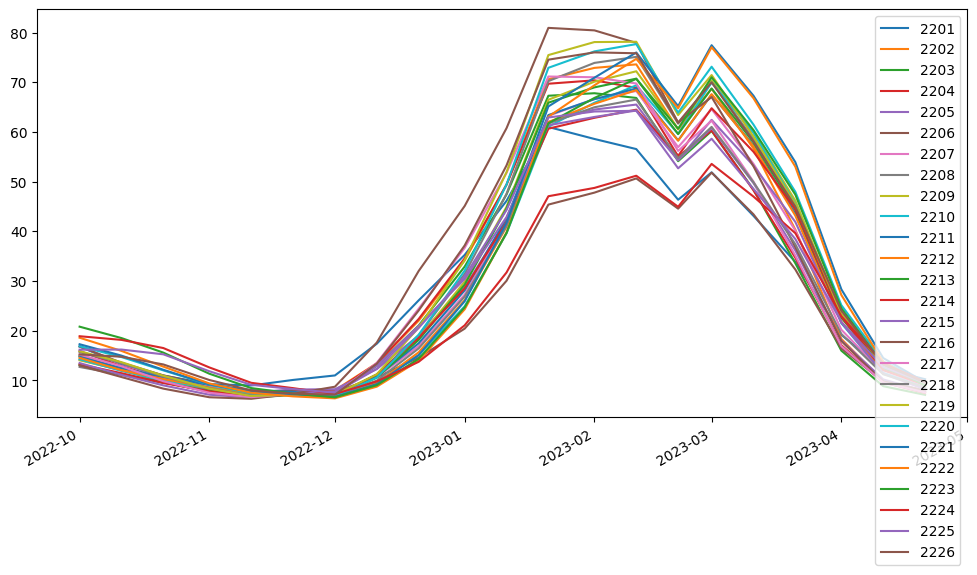

In [24]:
# Plot the dataframe
df2.plot(figsize = (12,6))

In [25]:
# save the dataframe and download to local folder
file_name3 = f'decadal_AETI_timeseries_for_{farm_name}_field.csv'
df2.to_csv(file_name3)

#download the two csv files
files.download(file_name3)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# # if you want to delete a folder use the code belwo.
# !rm -rf /content/L3-AETI-D
# !rm -rf /content/tifs
# !rm -rf /content/L3-AETI-D.zip